# Librerias

In [1]:
import pandas as pd
import numpy as np

In [2]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.preprocessing import StandardScaler , OrdinalEncoder, LabelEncoder

# Funciones

# Importar Bases de Datos

In [16]:
calendario = pd.read_csv("data/daily_calendar_with_events.csv")
precios = pd.read_csv("data/item_prices.csv")
ventas = pd.read_csv("data/item_sales.csv")

# Preproccesing

## Tabla Ventas Modificada

In [19]:
ultimodia=int(str(ventas.columns.to_list()[-1]).split("_")[1]) # buscamos el ultimo dia (ultima columna del DF)
lista=[ultimodia+x for x in range(1,29)] # creamos una lista con los siguientes 28 dias

for i in lista:
    colname="d_"+str(i)
    ventas[colname]=0 #creamos una columna por cada dia adicional con ventas 0.

idlist=[]
LE=LabelEncoder()
iditem =LE.fit(ventas["item"])
idlist.append({l: i for (i, l) in enumerate(iditem.classes_)})
idcat =LE.fit(ventas["category"])
idlist.append( {l: i for (i, l) in enumerate(idcat.classes_)})
iddep = LE.fit(ventas["department"])
idlist.append({l: i for (i, l) in enumerate(iddep.classes_)})
idsto =LE.fit(ventas["store"])
idlist.append({l: i for (i, l) in enumerate(idsto.classes_)})
idstocode =LE.fit(ventas["store_code"])
idlist.append({l: i for (i, l) in enumerate(idstocode.classes_)})
idreg =LE.fit(ventas["region"])
idlist.append({l: i for (i, l) in enumerate(idreg.classes_)})

for i in zip(ventas.columns[1:7].tolist(),idlist):
    
    ventas[i[0]]= ventas[i[0]].replace(i[1]).astype(int)


ventasmelt=ventas.melt(id_vars=ventas.columns[:7],value_vars=ventas.columns[7:],var_name="d",value_name="Cantidad") #Transformacion de BD, dias por Fila

#verificamos nulos
if len(ventasmelt.isnull().sum()[ventasmelt.isnull().sum() > 0]) ==0:
    print("Sin nulos")
else:
    print("Columnas con nulos: ", ventasmelt.isnull().sum()[ventasmelt.isnull().sum() > 0])

#verificamos filas duplicadas, las eliminamos y reseteamos el indice
print("Numero de filas duplicadas: ",len(ventasmelt[ventasmelt.duplicated(keep=False)]))
ventasmelt.drop_duplicates(inplace=True)
ventasmelt.reset_index(drop=True,inplace=True)

print("Suma de ventas totales: ",ventasmelt["Cantidad"].sum())
print("Observaciones con ventas 0: ",len(ventasmelt[ventasmelt["Cantidad"]==0].index))

for i in ventasmelt:
    if i !="Cantidad" and i !="d" :
        print(f"Numero de {i} unicos",ventasmelt[i].nunique())

print("Dimensiones DF tratado: ",ventasmelt.shape)


Sin nulos
Numero de filas duplicadas:  0
Suma de ventas totales:  65695409
Observaciones con ventas 0:  40630814
Numero de id unicos 30490
Numero de item unicos 3049
Numero de category unicos 3
Numero de department unicos 7
Numero de store unicos 10
Numero de store_code unicos 10
Numero de region unicos 3
Dimensiones DF tratado:  (59181090, 9)


In [20]:
ventas=ventasmelt.copy()

In [21]:
ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 9 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   id          object
 1   item        int32 
 2   category    int32 
 3   department  int32 
 4   store       int32 
 5   store_code  int32 
 6   region      int32 
 7   d           object
 8   Cantidad    int64 
dtypes: int32(6), int64(1), object(2)
memory usage: 2.6+ GB


In [22]:
ventas.head()

,id,item,category,department,store,store_code,region,d,Cantidad
0,ACCESORIES_1_001_NYC_1,0,0,0,2,3,1,d_1,0
1,ACCESORIES_1_002_NYC_1,1,0,0,2,3,1,d_1,0
2,ACCESORIES_1_003_NYC_1,2,0,0,2,3,1,d_1,0
3,ACCESORIES_1_004_NYC_1,3,0,0,2,3,1,d_1,0
4,ACCESORIES_1_005_NYC_1,4,0,0,2,3,1,d_1,0


## Tabla Calendario Modificada

In [23]:
calendario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         1913 non-null   object
 1   weekday      1913 non-null   object
 2   weekday_int  1913 non-null   int64 
 3   d            1913 non-null   object
 4   event        26 non-null     object
dtypes: int64(1), object(4)
memory usage: 74.9+ KB


In [24]:
calendario["date"]=pd.to_datetime(calendario["date"]) # formato fecha en columna date

In [25]:
calendario.sort_values(["date"], ascending = True, inplace = True)

In [26]:
print("Dimensiones DF original: ",calendario.shape)

#agregamos los ultimos 28 dias a proyectar
date_offset = pd.DateOffset(days=1)
ultimafila=calendario.iloc[-1:]
for dia in lista:
    new_row = ultimafila.copy()
    new_row['d'] = "d_"+str(1914)
    new_row['date'] = ultimafila["date"]+date_offset
    new_row['weekday']=new_row['date'].dt.day_name()
    new_row['weekday_int']=np.nan
    new_row['event']=np.nan
    ultimafila=new_row.copy()
    calendario = calendario.append(new_row, ignore_index=True)


#verificamos nulos
if len(calendario.isnull().sum()[calendario.isnull().sum() > 0]) ==0:
    print("Sin nulos")
else:
    print("Columnas con nulos: ", calendario.isnull().sum()[calendario.isnull().sum() > 0])

#verificamos filas duplicadas, las eliminamos y reseteamos el indice
print("Numero de filas duplicadas: ",len(calendario[calendario.duplicated(keep=False)]))
calendario.drop_duplicates(inplace=True)
calendario.reset_index(drop=True,inplace=True)

calendario["date"]=pd.to_datetime(calendario["date"]) # formato fecha en columna date

# calendario['week'] = calendario['date'].dt.isocalendar().week
# calendario['day'] = calendario['date'].dt.day
# calendario['month'] = calendario['date'].dt.month
calendario['year'] = calendario['date'].dt.year

# concatena semana y año en un string, agregando el 0 a semanas del 1 al 9
calendario['week'] = calendario['date'].dt.isocalendar().week.astype(str)
for i in range(len(calendario)):
    if int(calendario.loc[i,'week']) < 10:
        calendario.loc[i,'week'] = '0'+calendario.loc[i,'week']
calendario['year'] = calendario['date'].dt.isocalendar().year
calendario['yearweek']=calendario['year'].astype(str)+calendario['week']

#rellenamos nulos con 0 y pasamos dias con eventos a 1.
calendario["event"]=np.where(calendario["event"].isnull(),0,1)

#verificamos nulos
if len(calendario.isnull().sum()[calendario.isnull().sum() > 0]) ==0:
    print("Sin nulos")
else:
    print("Columnas con nulos: ", calendario.isnull().sum()[calendario.isnull().sum() > 0])

print("Numero de filas duplicadas: ",len(calendario[calendario.duplicated(keep=False)]))

print("Dimensiones DF tratado: ",calendario.shape)

Dimensiones DF original:  (1913, 5)
Columnas con nulos:  weekday_int      28
event          1915
dtype: int64
Numero de filas duplicadas:  0
Columnas con nulos:  weekday_int    28
dtype: int64
Numero de filas duplicadas:  0
Dimensiones DF tratado:  (1941, 8)


In [27]:
calendario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1941 non-null   datetime64[ns]
 1   weekday      1941 non-null   object        
 2   weekday_int  1913 non-null   float64       
 3   d            1941 non-null   object        
 4   event        1941 non-null   int32         
 5   year         1941 non-null   UInt32        
 6   week         1941 non-null   object        
 7   yearweek     1941 non-null   object        
dtypes: UInt32(1), datetime64[ns](1), float64(1), int32(1), object(4)
memory usage: 108.2+ KB


In [29]:
calendario.head()

,date,weekday,weekday_int,d,event,year,week,yearweek
0,2011-01-29,Saturday,1.0,d_1,0,2011,04,201104
1,2011-01-30,Sunday,2.0,d_2,0,2011,04,201104
2,2011-01-31,Monday,3.0,d_3,0,2011,05,201105
3,2011-02-01,Tuesday,4.0,d_4,0,2011,05,201105
4,2011-02-02,Wednesday,5.0,d_5,0,2011,05,201105


## Tabla Precios Modificada

In [52]:
print("Dimensiones DF original: ",precios.shape)

precios["id"]=precios["item"]+"_"+precios["store_code"] # crea id coditem+codstore



#verificamos nulos
if len(precios.isnull().sum()[precios.isnull().sum() > 0]) ==0:
    print("Sin nulos")
else:
    print("Columnas con nulos: ", precios.isnull().sum()[precios.isnull().sum() > 0])

#verificamos filas duplicadas, las eliminamos y reseteamos el indice
print("Numero de filas duplicadas: ",len(precios[precios.duplicated(keep=False)]))
precios.drop_duplicates(inplace=True)
precios.reset_index(drop=True,inplace=True)

#verificamos nulos
if len(precios.isnull().sum()[precios.isnull().sum() > 0]) ==0:
    print("Sin nulos")
else:
    print("Columnas con nulos: ", precios.isnull().sum()[precios.isnull().sum() > 0])

precios["yearweek"]=precios["yearweek"].astype(str)
precios["yearweek"]=precios["yearweek"].str.slice(stop=6) # quita .0 del string
# precios["year"]=precios["yearweek"].str.slice(stop=4) # crea columna con año
# precios["semana"]=precios["yearweek"].str.slice(start=4,stop=6) # crea columna con semana





print("Dimensiones DF tratado: ",precios.shape)

Dimensiones DF original:  (6965706, 5)
Columnas con nulos:  yearweek    243920
dtype: int64
Numero de filas duplicadas:  243495
Columnas con nulos:  yearweek    31800
dtype: int64
Dimensiones DF tratado:  (6753586, 6)


In [53]:
precios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6753586 entries, 0 to 6753585
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   item        object 
 1   category    object 
 2   store_code  object 
 3   yearweek    object 
 4   sell_price  float64
 5   id          object 
dtypes: float64(1), object(5)
memory usage: 309.2+ MB


In [54]:
precios.head()

,item,category,store_code,yearweek,sell_price,id
0,ACCESORIES_1_001,ACCESORIES,NYC_1,201328,12.7414,ACCESORIES_1_001_NYC_1
1,ACCESORIES_1_001,ACCESORIES,NYC_1,201329,12.7414,ACCESORIES_1_001_NYC_1
2,ACCESORIES_1_001,ACCESORIES,NYC_1,201330,10.9858,ACCESORIES_1_001_NYC_1
3,ACCESORIES_1_001,ACCESORIES,NYC_1,201331,10.9858,ACCESORIES_1_001_NYC_1
4,ACCESORIES_1_001,ACCESORIES,NYC_1,201332,10.9858,ACCESORIES_1_001_NYC_1


## Merge de los DF

In [55]:
df=pd.merge(ventas,calendario[["d","date","event","yearweek"]],how="right",on="d") # Join ventas con calendario

In [56]:
df["date"]=pd.to_datetime(df["date"])

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59181090 entries, 0 to 59181089
Data columns (total 12 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   item        int32         
 2   category    int32         
 3   department  int32         
 4   store       int32         
 5   store_code  int32         
 6   region      int32         
 7   d           object        
 8   Cantidad    int64         
 9   date        datetime64[ns]
 10  event       int32         
 11  yearweek    object        
dtypes: datetime64[ns](1), int32(7), int64(1), object(3)
memory usage: 4.2+ GB


In [58]:
df.shape

(59181090, 12)

In [59]:
df.drop(["store"],axis=1,inplace=True) # eliminamos columna duplicada

In [60]:
df.head()

,id,item,category,department,store_code,region,d,Cantidad,date,event,yearweek
0,ACCESORIES_1_001_NYC_1,0,0,0,3,1,d_1,0,2011-01-29,0,201104
1,ACCESORIES_1_002_NYC_1,1,0,0,3,1,d_1,0,2011-01-29,0,201104
2,ACCESORIES_1_003_NYC_1,2,0,0,3,1,d_1,0,2011-01-29,0,201104
3,ACCESORIES_1_004_NYC_1,3,0,0,3,1,d_1,0,2011-01-29,0,201104
4,ACCESORIES_1_005_NYC_1,4,0,0,3,1,d_1,0,2011-01-29,0,201104


In [61]:
df.sort_values(["id", "date"], ascending = True, inplace = True)

In [62]:
df["Cantidad"].sum()

65695409

In [63]:
df=pd.merge(df,precios[["id","yearweek","sell_price"]],how="left",on=["id","yearweek"]) #join con precios

In [64]:
df["Cantidad"].sum()

65695409

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59181090 entries, 0 to 59181089
Data columns (total 12 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   item        int32         
 2   category    int32         
 3   department  int32         
 4   store_code  int32         
 5   region      int32         
 6   d           object        
 7   Cantidad    int64         
 8   date        datetime64[ns]
 9   event       int32         
 10  yearweek    object        
 11  sell_price  float64       
dtypes: datetime64[ns](1), float64(1), int32(6), int64(1), object(3)
memory usage: 4.4+ GB


In [66]:
df.isnull().sum()

id                   0
item                 0
category             0
department           0
store_code           0
region               0
d                    0
Cantidad             0
date                 0
event                0
yearweek             0
sell_price    13153941
dtype: int64

In [67]:
# rellenamos nulos con el valor anterior o posterior si no encuentra el anterior.
df["sell_price"] = df.groupby("id", group_keys = False)["sell_price"].apply(lambda series: series.bfill().ffill())

In [68]:
df["sell_price"].isnull().sum() # verificamos nulos en sell price

0

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59181090 entries, 0 to 59181089
Data columns (total 12 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   item        int32         
 2   category    int32         
 3   department  int32         
 4   store_code  int32         
 5   region      int32         
 6   d           object        
 7   Cantidad    int64         
 8   date        datetime64[ns]
 9   event       int32         
 10  yearweek    object        
 11  sell_price  float64       
dtypes: datetime64[ns](1), float64(1), int32(6), int64(1), object(3)
memory usage: 4.4+ GB


In [70]:
df.head()

,id,item,category,department,store_code,region,d,Cantidad,date,event,yearweek,sell_price
0,ACCESORIES_1_001_BOS_1,0,0,0,0,0,d_1,0,2011-01-29,0,201104,12.7414
1,ACCESORIES_1_001_BOS_1,0,0,0,0,0,d_2,0,2011-01-30,0,201104,12.7414
2,ACCESORIES_1_001_BOS_1,0,0,0,0,0,d_3,0,2011-01-31,0,201105,12.7414
3,ACCESORIES_1_001_BOS_1,0,0,0,0,0,d_4,0,2011-02-01,0,201105,12.7414
4,ACCESORIES_1_001_BOS_1,0,0,0,0,0,d_5,0,2011-02-02,0,201105,12.7414


In [71]:
from pathlib import Path  
filepath = Path("data/tablafinal.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath,index=False)  

In [ ]:
df=pd.read_csv("data/tablafinal.csv")

# Mapping DF

## Agrupamos por semana

In [72]:
columnasbase=df.columns[:6].tolist()
columnasbase.append("yearweek")
columnasbase

['id', 'item', 'category', 'department', 'store_code', 'region', 'yearweek']

In [73]:
ventassem=df.groupby(by=columnasbase).agg({"Cantidad":"sum","sell_price":"mean","event":"sum"}).reset_index()

In [74]:
ventassem.shape

(8476220, 10)

In [75]:
ventassem.head()

,id,item,category,department,store_code,region,yearweek,Cantidad,sell_price,event
0,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201104,0,12.7414,0
1,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201105,0,12.7414,1
2,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201106,0,12.7414,0
3,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201107,0,12.7414,0
4,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201108,0,12.7414,0


In [76]:
ventassem["Cantidad"].sum()

65695409

In [77]:
ventassem["yearweek"].max()

'201620'

In [78]:
from pathlib import Path  
filepath = Path("data/ventassem.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
ventassem.to_csv(filepath,index=False)  

# EDA

## Graficos

<Axes: xlabel='region'>

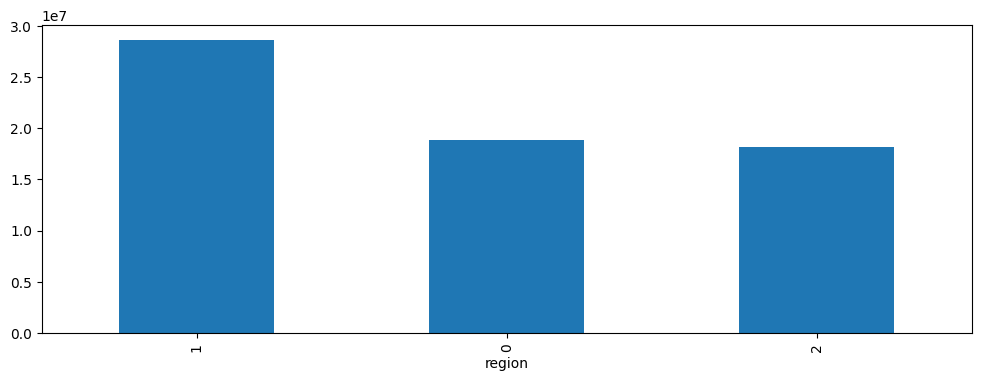

In [82]:

(df.groupby(["region"])["Cantidad"].sum().sort_values(ascending = False).plot(kind = "bar", figsize = (12, 4))


In [ ]:
(
    df.
    groupby(["store_code"])
    ["Cantidad"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

In [ ]:
(
    df.
    groupby(["category"])
    ["Cantidad"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

In [ ]:
(
    df.
    groupby(["department"])
    ["Cantidad"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

In [ ]:
y = df.set_index("date").resample("M")["Cantidad"].sum()

In [ ]:
fig = plt.figure(figsize = (12, 10))
ax = fig.subplots(1, 1)
ax.plot(y)
    
plt.suptitle(t = "Ventas Totales", fontsize = 20)